# Методы оптимизации

In [8]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

from scipy.optimize import minimize, minimize_scalar, linprog

!pip install autograd
import autograd.numpy as np
from autograd import elementwise_grad
from autograd import jacobian

from IPython.display import display, Math

In [9]:
def print_matrix(array):
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{number}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))

In [10]:
def print_result(method, result):
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(result)) + 1, result)
    plt.title(method, fontsize=14)
    plt.xlabel('Число итераций', fontsize=12)
    plt.ylabel('Значение функционала', fontsize=12)
    plt.grid(True)
    plt.show()

# Метод Ньютона

**Метод Ньютона (МН)** ориентирован на решение задач минимизации $J(u) \rightarrow \inf, u \in U \subset H$.
  
$$ u_{k+1} = u_k + \alpha (\hat{u_k} - u_k),\quad \hat{u_k} = \underset{u \in U}{\arg\min} \ m_k(u)$$ 
$$m_k(u) = J(u_k) + \left<\nabla J(u_k), u - u_k\right> + \frac12 \left<J''(u_k)(u - u_k), u - u_k\right>$$

В классическом варианте МН: $\quad\alpha = 1$

In [11]:
def Newton(J, u_0, constraints, max_iter=100, alpha=1., tol=1e-6):
    grad_J = elementwise_grad(J) #gradient
    hess_J = jacobian(grad_J) #hessian

    def m_k(u, u_k): 
        return J(u_k) + grad_J(u_k) @ (u - u_k) + (hess_J(u_k) @ (u - u_k)) @ (u - u_k) / 2

    convergence_hist = []
    u_k = None
    u_k1 = u_0
    iter_num = 0

    while True:
        if iter_num >= max_iter:
            print('Достигнуто максимальное число итераций')
            break
        if u_k is not None and np.linalg.norm(u_k - u_k1) < tol:
            print('Достигнут необходимый порог')
            break
        u_k = u_k1
        u_argmin = np.array(minimize(
            fun=lambda u: m_k(u, u_k1), 
            x0=u_k1, 
            method='COBYLA', 
            constraints=constraints, 
            tol=tol, 
            options={'maxiter': 100}
        ).x)
        #COBYLA (Constrained Optimization BY Linear Approximations) — это алгоритм минимизации,
        #который используется для задач нелинейного программирования с ограничениями

        u_k1 = u_k1 + alpha * (u_argmin - u_k1)
        convergence_hist.append(J(u_k1))
        iter_num += 1
        
    print(f'Сошёлся за {iter_num} итераций')
    print(f'Значение функционала: {J(u_k1)}')
    return u_k1, convergence_hist

## Стандартные функционалы

Пример 1:
$$ J(u) = \left<Au, u \right>  \to \inf $$

$$J'(u) = (A + A^*)u,\  J''(u) = (A + A^*)$$

$$ U = \{u \in H \ | \ \|u\| \leq c \}$$

Генерируем матрицу A:

In [12]:
n = 100
a = np.random.randint(-100, 100 + 1, size=(n, n))
A = (a + a.T) / 2
A = A.dot(A.T)

In [13]:
print_matrix(A)

<IPython.core.display.Math object>

In [14]:
J1 = lambda u: (A @ u) @ u
с = 10

In [15]:
u0 = np.random.randint(-100, 100, size=n)
constraints = [{'type': 'ineq', 'fun': lambda u: -np.linalg.norm(u) + с}]
result = Newton(J1, u0, constraints)

Достигнуто максимальное число итераций
Сошёлся за 100 итераций
Значение функционала: 19869271635.5


Минимизирующее u_*: [-35.  24.  20.  72.  19.   1.  32.  22.  68.  58.  45.  17. -14.  -2.
  39.   6.  20.  46.  47.  39.   8.  66.  31.  94. -20. -45. -40.  67.
  -8.  43. -18.  23.  37. -11.  49.  78.  12.  76.  34.  -7. -16.   4.
  71. -25.  39.  10.  18.  86.  68.   6.  86.  19.  21.  65.  82.  73.
   8.  53. -63.  19.  10.  99. 101.  31.  89.  86.   3. -36.  -5.  15.
 -24.  91.  33.  64.  22. -10.  40.  34. -67.  12. -12.  22.  75.   2.
  45.  27.  96.  28.  72.  72.  99.  36. -18.  98.  15.  24. -24.  59.
  52. -50.]
||u_*||: 492.12904811644677
Значение функционала J(u_*): 19869271635.5


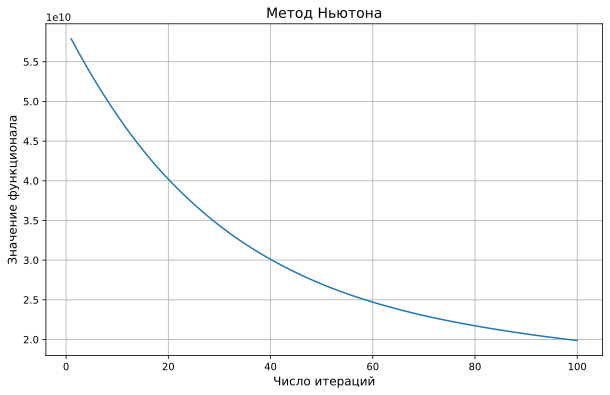

In [17]:
print(f'Минимизирующее u_*: {result[0]}')
print(f'||u_*||: {np.linalg.norm(result[0])}')
print(f'Значение функционала J(u_*): {J1(result[0])}')
print_result('Метод Ньютона', result[1])

Пример 2:

$$ J(u) = || Au - b||^2 \to \inf $$

$$ J'(u) = 2 A^*(Au - b), \ J''(u) = 2 A^*A $$

$$ U = \{u \in H \ | \ \|u\| \leq c \}$$

In [30]:
m, n = 10, 50
A = np.random.randn(m, n)
b = np.random.randn(m)
c = 1

In [31]:
print_matrix(A)

<IPython.core.display.Math object>

In [32]:
print_matrix(b)

<IPython.core.display.Math object>

In [33]:
J2 = lambda u: np.linalg.norm(A @ u - b) ** 2

In [34]:
u0 = np.random.randn(n)
constraints = [{'type': 'ineq', 'fun': lambda u: -np.linalg.norm(u) + c}]
result = Newton(J2, u0, constraints)

Достигнут необходимый порог
Сошёлся за 9 итераций
Значение функционала: 0.16592845789021718


Минимизирующее u_*: [ 0.83080846  0.70551386 -0.20489147  0.63421925  0.28172432  0.00440127
 -0.19686495  0.70594345 -0.03022642 -0.32995063  0.19804478  0.31560857
  0.30397878  0.20663541  0.320376   -0.04011485 -0.02060253  0.36229143
  0.45003815 -0.10770417  0.5774553  -0.4237937  -0.19414357 -0.24070568
  0.97199309  0.2855266  -0.27103237 -0.13208357 -0.46794344  0.30340112
  0.78745548  0.10077672  0.7368437  -0.50812629  0.60521159 -0.30906035
  0.43432659 -0.02690289  0.25513112 -0.00368312 -0.30761866 -0.46181548
  0.11610744 -0.8017888  -0.14592806 -0.86971698 -0.51123676  0.03643791
  0.47307773 -0.36504644]
||u_*||: 3.1030210319262514
Значение функционала J(u_*): 0.16592845789021718


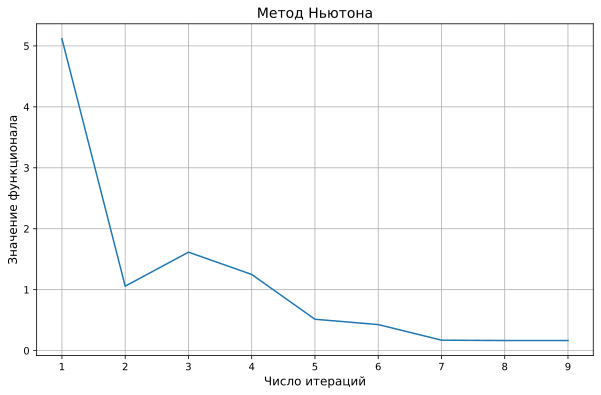

In [36]:
print(f'Минимизирующее u_*: {result[0]}')
print(f'||u_*||: {np.linalg.norm(result[0])}')
print(f'Значение функционала J(u_*): {J2(result[0])}')
print_result('Метод Ньютона', result[1])

## Проверка

Проверим на следующих значениях:
$$ A = \begin{bmatrix}
    2 & 1\\
    1 & 2\\
\end{bmatrix};\quad b = \begin{bmatrix}
4\\
4
\end{bmatrix}; \quad c = 1.
$$
В таком случае решение имеет вид:
$$u_* = \begin{bmatrix} \frac{\sqrt{2}}{2}\\ \frac{\sqrt{2}}{2} \end{bmatrix}; \quad J_* = 41 - 24\sqrt{2}.$$

In [37]:
A = np.array([[2, 1], [1 , 2]])
b = np.array([4, 4])
n = 2

In [38]:
u0 = np.random.randn(n)
constraints = [{'type': 'ineq', 'fun': lambda u: -np.linalg.norm(u) + c}]
result = Newton(J2, u0, constraints)

Достигнут необходимый порог
Сошёлся за 3 итераций
Значение функционала: 7.058874503022692


Минимизирующее u_*: [0.70710669 0.70710687]
||u_*||: 1.0000000000014535
Значение функционала J(u_*): 7.058874503022692


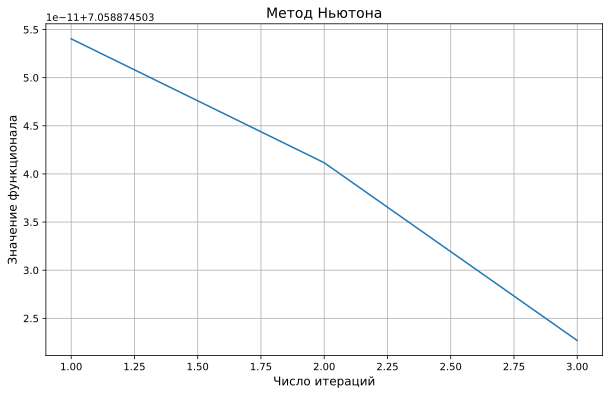

In [43]:
print(f'Минимизирующее u_*: {result[0]}')
print(f'||u_*||: {np.linalg.norm(result[0])}')
print(f'Значение функционала J(u_*): {J2(result[0])}')
print_result('Метод Ньютона', result[1])

In [44]:
print(np.linalg.norm(result[0] - np.array([np.sqrt(2) / 2, np.sqrt(2) / 2])))
print((J2(result[0]) - (41 - 24 * np.sqrt(2))) ** 2)

1.2645309160024898e-07
5.3003425461166555e-22


Пример 3:

$$ J(u) = ||u||^2+\left <u,a \right>^2 + \left< u, b \right > \to \inf $$   
$$ U = \{u \in H \ | \ ||u|| \leq 2,  \left< a, u \right> \geq 1 \} $$
$$ ||a||=1, ||b||=2, \left< a, b \right> = 0 $$

In [45]:
a = np.array([np.sqrt(3) / np.sqrt(8), 0, 0, 0, np.sqrt(3) / np.sqrt(8), 0, np.sqrt(2) / np.sqrt(8), 0])
b = np.array([0, 4 / np.sqrt(8), 4 / np.sqrt(8), 0, 0, 0, 0, 0])
J3 = lambda u: np.linalg.norm(u) ** 2 + (u @ a) ** 2 + u @ b

In [46]:
u0 = a
constraints = [{'type': 'ineq', 'fun': lambda u: -np.linalg.norm(u) + 2}, {'type': 'ineq', 'fun': lambda u: (a @ u) - 1}]
result = Newton(J3, u0, constraints)

Достигнут необходимый порог
Сошёлся за 9 итераций
Значение функционала: 1.0000000000015699


Минимизирующее u_*: [ 6.12372477e-01 -7.07107251e-01 -7.07107789e-01 -6.70709985e-08
  6.12372220e-01 -5.74304944e-08  5.00000214e-01 -4.83331273e-07]
||u_*||: 1.4142143008615975
Значение функционала J(u_*): 1.0000000000015699


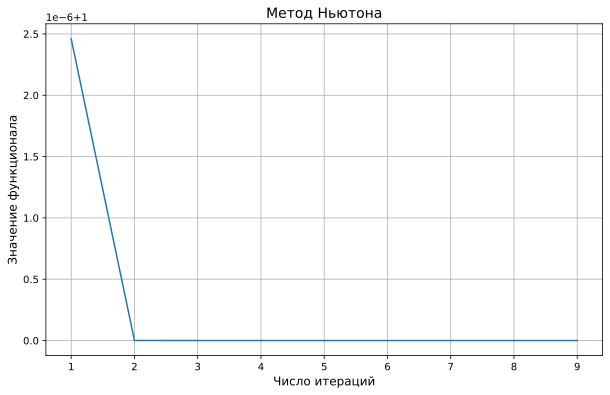

In [47]:
print(f'Минимизирующее u_*: {result[0]}')
print(f'||u_*||: {np.linalg.norm(result[0])}')
print(f'Значение функционала J(u_*): {J3(result[0])}')
print_result('Метод Ньютона', result[1])

## Проверка

Аналитически полученное решение: $u_* = a - \frac b2$.

In [49]:
print(np.linalg.norm(result[0] - (a - b / 2)))
print((J3(result[0]) - J3(a - b / 2)) ** 2)

1.2533678410942395e-06
2.465840350201564e-24


# Симплекс-метод

Алгоритм решения оптимизационной задачи линейного программирования путём перебора вершин выпуклого многогранника в многомерном пространстве.  
Сущность метода: построение базисных решений, на которых монотонно убывает линейный функционал, до ситуации, когда выполняются необходимые условия локальной оптимальности.

In [50]:
from autograd.builtins import itertools
from sympy import Matrix

def SimplexMethod(A, b, c):
    # Находит базисную точку
    basis_vars = np.arange(A.shape[1])
    permuts = itertools.permutations(basis_vars)
    permut = np.array(next(iter(permuts)))

    # Выбирает единичную матрицу
    new_matrix, ind = Matrix(np.concatenate((A[:, permut], b[:, None]), axis=1)).rref()
    # Приводит матрицу к строковой эшелонной форме
    new_matrix, ind =  np.array(new_matrix).astype(np.float64), permut[np.array(ind)]
    # Преобразует матрицу обратно в numpy массив и сохраняет индексы базисных переменных
        
    new_b, new_matrix = new_matrix[:, -1], new_matrix[:, :-1]
    # Разделяет правую часть и обновленную матрицу A
    new_A = new_matrix[:, np.argsort(permut)]
    # Переставляет столбцы матрицы A в исходный порядок

    A, b, basis_vars = new_A, new_b, ind
    # Обновляет матрицу A, вектор b и базисные переменные


    v_k = np.zeros(A.shape[1])
    # Инициализирует вектор значений переменных нулями
    v_k[basis_vars] = b
    # Присваивает базисным переменным их значения из вектора b
    
    iter_num = 0  # Счетчик итераций
    convergence_hist = []  # История сходимости
    while True:
        convergence_hist.append(c @ v_k)
        # Добавляет значение целевой функции на текущей итерации в историю сходимости
        free_vars = list(np.setdiff1d(np.arange(A.shape[1]), basis_vars))
        # Находит индексы свободных переменных
        B_1F = np.linalg.inv(A[:, basis_vars]) @ A[:, free_vars]
        # Вычисляет произведение обратной матрицы базисных переменных и свободных переменных
        delta = B_1F.T @ c[basis_vars] - c[free_vars]
        # Вычисляет коэффициенты для свободных переменных в целевой функции

        if (delta > 0).sum() == 0:
            # Если все коэффициенты delta не положительные, решение найдено
            print(f'Сошёлся за {iter_num + 1} итераций')
            print(f'Значение функционала: {c @ v_k}')
            return v_k, convergence_hist
        
        free_vars_perspective = list(np.array(free_vars)[delta > 0])
        # Находит перспективные свободные переменные с положительными коэффициентами delta
        
        A_j_blend = A[:, min(free_vars_perspective)]
        # Берет столбец матрицы A, соответствующий минимальному индексу среди перспективных свободных переменных
        B_1A = np.linalg.inv(A[:, basis_vars]) @ A_j_blend
        # Вычисляет произведение обратной матрицы базисных переменных и выбранного столбца

        if (B_1A <= 0).all():
            # Если все элементы B_1A не положительные, то решений нет
            print('Нет решений')
            print(f'Разошёлся за {iter_num + 1} итераций')
            print(f'Значение функционала: {-np.inf}')
            return -np.inf, convergence_hist
        
        I = np.where(B_1A > 0)[0]
        # Находит индексы положительных элементов B_1A
        I_min = []
        min_frac = float('inf')
        for i in I:
            # Определяет минимальное отношение v_k[basis_vars[i]] / B_1A[i] и соответствующие индексы
            if v_k[basis_vars[i]] / B_1A[i] == min_frac:
                I_min.append(basis_vars[i])
            elif v_k[basis_vars[i]] / B_1A[i] < min_frac:
                I_min = [basis_vars[i]]
                min_frac = v_k[basis_vars[i]] / B_1A[i]
        u_free = np.zeros(A.shape[1] - A.shape[0])
        # Инициализирует вектор свободных переменных нулями
        u_free[min(np.where(delta > 0)[0])] = min_frac
        # Присваивает минимальное отношение соответствующему элементу вектора свободных переменных
        v_k1 = v_k[basis_vars] - (B_1F @ u_free.reshape(-1, 1)).reshape(-1)
        # Обновляет значения базисных переменных
        v_res = np.zeros_like(v_k)
        # Инициализирует результирующий вектор переменных нулями
        v_res[basis_vars] = v_k1
        # Присваивает базисным переменным обновленные значения
        v_res[free_vars] = u_free.reshape(-1)
        # Присваивает свободным переменным обновленные значения
        v_k = v_res
        # Обновляет вектор переменных
        basis_vars = list(basis_vars)
        # Преобразует базисные переменные в список
        basis_vars.remove(min(I_min))
        # Удаляет минимальную базисную переменную
        basis_vars.append(min(free_vars_perspective))
        # Добавляет минимальную свободную переменную к базисным
        basis_vars = np.array(sorted(basis_vars))
        # Сортирует базисные переменные
        iter_num += 1
        # Увеличивает счетчик итераций

Пример 1:

$$ J(u) = -u_1 + u_2 - 3u_3  = \left< c, u \right> \to \inf $$

$$ c = (-1, 1, -3)^T $$

$$ U = \{u \in H \ | \ u \geq 0,  Au=b \} $$

$$ A = \begin{bmatrix} -1 & 2 & 1 \\ 1 & 3 & 1 \\ 1 & 1 & -1 \end{bmatrix}, b = \begin{bmatrix} 2 \\ 6 \\ 2 \end{bmatrix} $$

In [51]:
A = np.array([[-1, 2, 1], 
              [1, 3, 1],
              [1, 1, -1]])
b = np.array([2, 6, 2])
c = np.array([-1, 1, -3])

In [53]:
res = SimplexMethod(A, b, c)

Сошёлся за 1 итераций
Значение функционала: -2.0


Метод 'highs' (High-Performance Interior Point Method for Linear Programming) - это высокопроизводительный метод внутренней точки для решения линейных задач программирования. Он работает путем поиска точки внутри допустимого множества, где градиент целевой функции и градиент ограничений равенства становятся близкими к нулю. Этот метод обеспечивает быструю сходимость и хорошую производительность на больших и разреженных задачах.

In [55]:
print(f'Минимизирующее u_*: {res[0]}')

Минимизирующее u_*: [1.33333333 1.33333333 0.66666667]


In [56]:
print('Проверим результат:')
ans = linprog(c, A_eq=A, b_eq=b, method='highs')
print(f'Минимизирующее u_*: {ans.x}')
print(f'Значение функционала: {ans.fun}')
print(f'Разница значений: {np.abs(c @ res[0] - ans.fun)}')

Проверим результат:
Минимизирующее u_*: [1.33333333 1.33333333 0.66666667]
Значение функционала: -1.9999999999999998
Разница значений: 2.220446049250313e-16


Пример 2:

$$ J(u)=u_1+u_2-u_3+u_5=\left<c, u \right> \to \inf $$

$$ c=(1, 1, -1, 0, 1)^T $$

$$ U = \{u \in H \ | \ u \geq 0,  Au=b \} $$

$$ A = \begin{bmatrix} 1 & 0 & 0 & 1 & -1 \\ 1 & 1 & 0 & 2 & 0 \\ 0 & 0 & 1 & 1 & 0 \end{bmatrix}, b = \begin{bmatrix} 1 \\ 3 \\ 1 \end{bmatrix} $$

In [57]:
A = np.array([[1, 0, 0, 1, -1], 
              [1, 1, 0, 2, 0], 
              [0, 0, 1, 1, 0]])
b = np.array([1, 3, 1])
c = np.array([1, 1, -1, 0, 1])

In [60]:
res = SimplexMethod(A, b, c)

Сошёлся за 2 итераций
Значение функционала: 1.0


In [61]:
print(f'Минимизирующее u_*: {res[0]}')

Минимизирующее u_*: [0. 1. 0. 1. 0.]


In [62]:
print('Проверим результат:')
ans = linprog(c, A_eq=A, b_eq=b, method='highs')
print(f'Минимизирующее u_*: {ans.x}')
print(f'Значение функционала: {ans.fun}')
print(f'Разница значений: {np.abs(c @ res[0] - ans.fun)}')

Проверим результат:
Минимизирующее u_*: [-0.  1.  0.  1.  0.]
Значение функционала: 1.0
Разница значений: 0.0


Пример 3:

$$ J(u)=-3u_1-u_2-u_3+u_4=\left<c, u \right> \to \inf $$

$$ c=(-3, -1, -1, 1)^T $$

$$ U = \{u \in H \ | \ u \geq 0,  Au=b \} $$

$$ A = \begin{bmatrix} 1 & -1 & 1 & 0 \\ 2 & 1 & 0 & 1 \end{bmatrix}, b = \begin{bmatrix} 1 \\ 3 \end{bmatrix} $$


In [63]:
A = np.array([[1, -1, 1, 0], 
              [2, 1, 0, 1]])
b = np.array([1, 3])
c = np.array([-3, -1, -1, 1])

In [65]:
res = SimplexMethod(A, b, c)

Сошёлся за 2 итераций
Значение функционала: -7.0


In [66]:
print(f'Минимизирующее u_*: {res[0]}')

Минимизирующее u_*: [0. 3. 4. 0.]


In [38]:
print('Проверим результат:')
ans = linprog(c, A_eq=A, b_eq=b, method='highs')
print(f'Минимизирующее u_*: {ans.x}')
print(f'Значение функционала: {ans.fun}')
print(f'Разница значений: {np.abs(c @ res[0] - ans.fun)}')

Проверим результат:
Минимизирующее u_*: [0. 3. 4. 0.]
Значение функционала: -7.0
Разница значений: 0.0


Пример 4 (большая размерность):

In [77]:
m, n = 50, 100 # ограничения, переменные
A = np.random.randn(m, n - m) # матрица огр неравенства
A = np.concatenate([np.eye(m), A], axis=1) # добавляется единичная матрица слева, чтобы превратить огр в равенства
b = np.random.uniform(size=m) # случайный вектор правых частей
c = np.random.randn(n - m) + 1 # Создается случайный вектор коэффициентов целевой функции
c = np.concatenate([np.zeros(m), c], axis=0) # Вектор коэффициентов целевой функции обновляется, добавляя нули для переменных, связанных с ограничениями равенства

In [78]:
res = SimplexMethod(A, b, c)

Сошёлся за 33 итераций
Значение функционала: -0.22846409568184403


In [79]:
print(f'Минимизирующее u_*: {res[0]}')

Минимизирующее u_*: [0.84594016 0.97904907 0.28225507 0.08325977 0.         1.22179899
 0.12950156 1.25277822 0.         0.31229943 0.85792731 0.46649712
 0.28494366 0.32976507 0.         0.         0.         1.71175445
 0.5401099  0.         0.16826682 0.63259704 0.6235351  0.4720595
 0.         0.50279899 0.63825303 0.70799814 0.47938536 0.91710671
 0.         1.10918056 0.18266284 0.57230195 0.73807648 0.65628485
 0.19280944 1.31375916 0.77263194 0.72731471 0.45523495 0.82155195
 0.72850788 0.         0.47112919 0.         0.66996176 0.79258695
 0.76258805 0.2781393  0.         0.         0.         0.
 0.         0.0991636  0.         0.         0.         0.02044773
 0.13756491 0.         0.         0.01913614 0.         0.02016586
 0.         0.07267045 0.08080982 0.         0.         0.
 0.         0.00236839 0.09763048 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0581859
 0.      

In [80]:
print('Проверим результат:')
ans = linprog(c, A_eq=A, b_eq=b, method='highs')
print(f'Минимизирующее u_*: {ans.x}')
print(f'Значение функционала: {ans.fun}')
print(f'Разница значений: {np.abs(c @ res[0] - ans.fun)}')

Проверим результат:
Минимизирующее u_*: [0.84594016 0.97904907 0.28225507 0.08325977 0.         1.22179899
 0.12950156 1.25277822 0.         0.31229943 0.85792731 0.46649712
 0.28494366 0.32976507 0.         0.         0.         1.71175445
 0.5401099  0.         0.16826682 0.63259704 0.6235351  0.4720595
 0.         0.50279899 0.63825303 0.70799814 0.47938536 0.91710671
 0.         1.10918056 0.18266284 0.57230195 0.73807648 0.65628485
 0.19280944 1.31375916 0.77263194 0.72731471 0.45523495 0.82155195
 0.72850788 0.         0.47112919 0.         0.66996176 0.79258695
 0.76258805 0.2781393  0.         0.         0.         0.
 0.         0.0991636  0.         0.         0.         0.02044773
 0.13756491 0.         0.         0.01913614 0.         0.02016586
 0.         0.07267045 0.08080982 0.         0.         0.
 0.         0.00236839 0.09763048 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        

In [85]:
m, n = 100, 200
A = np.random.randn(m, n - m)
A = np.concatenate([np.eye(m), A], axis=1)
b = np.random.uniform(size=m)
c = np.random.randn(n - m) + 1
c = np.concatenate([np.zeros(m), c], axis=0)

In [86]:
res = SimplexMethod(A, b, c)

Сошёлся за 221 итераций
Значение функционала: -0.4647664556079023


In [87]:
print(f'Минимизирующее u_*: {res[0]}')

Минимизирующее u_*: [0.         0.         0.88141689 0.52626036 0.75341223 0.84606443
 0.         0.         0.38845393 0.45461882 0.25353787 0.14436532
 0.78876807 0.45531932 1.36369039 0.92078237 0.19275188 0.
 0.00671649 0.52634122 1.02649659 0.25899278 1.165191   0.71077108
 0.25597657 0.         0.5369823  0.3541946  0.4078975  0.93827628
 0.01367442 0.         0.35846168 0.52096942 0.9257358  1.30976366
 0.         0.67116092 0.33938535 0.42219754 0.30633715 0.
 0.         0.89447771 0.42022817 0.91763467 0.75669692 0.
 1.08109777 0.14536071 1.00584629 0.55416758 0.09982778 0.
 0.10367487 0.4367294  0.         0.         0.         0.1626518
 0.         0.         1.29782446 0.32361319 1.19977092 0.
 1.13363098 0.81880105 0.40427627 0.         0.31370554 0.34325224
 0.70727509 0.37494932 0.94093999 0.         0.83587633 0.82696133
 0.01857128 0.84254066 0.3832612  1.64987481 0.80911837 1.15226847
 0.81408122 0.         0.04494556 0.22383772 0.97328755 0.85297517
 0.16299659 0.46

In [88]:
print('Проверим результат:')
ans = linprog(c, A_eq=A, b_eq=b, method='highs')
print(f'Минимизирующее u_*: {ans.x}')
print(f'Значение функционала: {ans.fun}')
print(f'Разница значений: {np.abs(c @ res[0] - ans.fun)}')

Проверим результат:
Минимизирующее u_*: [0.         0.         0.88141689 0.52626036 0.75341223 0.84606443
 0.         0.         0.38845393 0.45461882 0.25353787 0.14436532
 0.78876807 0.45531932 1.36369039 0.92078237 0.19275188 0.
 0.00671649 0.52634122 1.02649659 0.25899278 1.165191   0.71077108
 0.25597657 0.         0.5369823  0.3541946  0.4078975  0.93827628
 0.01367442 0.         0.35846168 0.52096942 0.9257358  1.30976366
 0.         0.67116092 0.33938535 0.42219754 0.30633715 0.
 0.         0.89447771 0.42022817 0.91763467 0.75669692 0.
 1.08109777 0.14536071 1.00584629 0.55416758 0.09982778 0.
 0.10367487 0.4367294  0.         0.         0.         0.1626518
 0.         0.         1.29782446 0.32361319 1.19977092 0.
 1.13363098 0.81880105 0.40427627 0.         0.31370554 0.34325224
 0.70727509 0.37494932 0.94093999 0.         0.83587633 0.82696133
 0.01857128 0.84254066 0.3832612  1.64987481 0.80911837 1.15226847
 0.81408122 0.         0.04494556 0.22383772 0.97328755 0.85297

# Метод условного градиента

**Метод условного градиента (МУГ)** ориентирован на решение задач минимизации $J(u) \rightarrow \inf, u \in U \subset H$.
$$ p_k = \hat {u_k} - u_k, \  \hat {u_k} = \underset{u \in U}{\arg\min} \ m_k(u), \  m_k(u) = J(u_k) + \left<J'(u_k), u - u_k\right>$$
$$ \alpha_k = \underset{\alpha \in [0, 1]}{\arg\min} \ J(u_k + \alpha p_k) = \underset{\alpha \in [0, 1]}{\arg\min} \ J(u_k + \alpha (\hat {u_k} - u_k)) $$
$$ u_{k+1} = u_k + \alpha_k p_k = u_k + \alpha_k (\hat {u_k} - u_k) $$

In [47]:
def ConditionalGradientMethod(J, u_0, constraints, max_iter=100, tol=1e-6, alpha=None):
    grad_J = elementwise_grad(J)

    def m_k(u, u_k): 
        return J(u_k) + grad_J(u_k) @ (u - u_k)

    convergence_hist = []
    u_k = None
    u_k1 = u_0
    iter_num = 0
    while True:
        if iter_num >= max_iter:
            print('Достигнуто максимальное количество итераций')
            break
        if u_k is not None and np.linalg.norm(u_k - u_k1) < tol:
            print('Достигнут необходимый порог')
            break
        u_k = u_k1
        u_argmin = np.array(minimize(fun=lambda u: m_k(u, u_k1), x0=u_k1, method='COBYLA', constraints=constraints, tol=tol, options={'maxiter': 100}).x)
        if alpha is None:
            alpha_k = minimize_scalar(fun=lambda a: J(u_k1 + a * (u_argmin - u_k1)), bounds=(0, 1), tol=tol, options={'maxiter': 10}).x
        else:
            alpha_k = alpha
        u_k1 = u_k1 + alpha_k * (u_argmin - u_k1)
        convergence_hist.append(J(u_k1))
        iter_num += 1

    print(f'Сходится на {iter_num} итерациях')
    print(f'Значение функционала: {J(u_k1)}')
    return u_k1, convergence_hist

Пример 1:

$$ J(u) = \frac 12 ||u-a||^4+||u-b||^2 \to \inf $$

$$ U = \{u \in H \ | \left< a + b, u \right> \geq 2 \} $$

$$ ||a||=1, \ ||b||=1, \ \left< a, b \right>=0 $$

In [48]:
a = np.array([1/2, 0, 1/2, 0, 1/2, 0, 1/2, 0])
b = np.array([0, 1/2, 0, 1/2, 0, 1/2, 0, 1/2])
J4 = lambda u: np.linalg.norm(u - a) ** 4 / 2 + np.linalg.norm(u - b) ** 2

In [49]:
u0 = 2 * a
constraints = [{"type": "ineq", "fun": lambda u: (a + b) @ u - 2}]
result = ConditionalGradientMethod(J4, u0, constraints)

/Users/ivanmorozov/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Достигнуто максимальное количество итераций
Сходится на 100 итерациях
Значение функционала: 66.97545777231511


Минимизирующее u_*: [ 1.82055707 -0.82055707  1.82055707 -0.82055707  1.82055707 -0.82055707
  1.82055707 -0.82055707]
||u_*||: 3.9938662685373663
Значение функционала J(u_*): 66.97545777231511


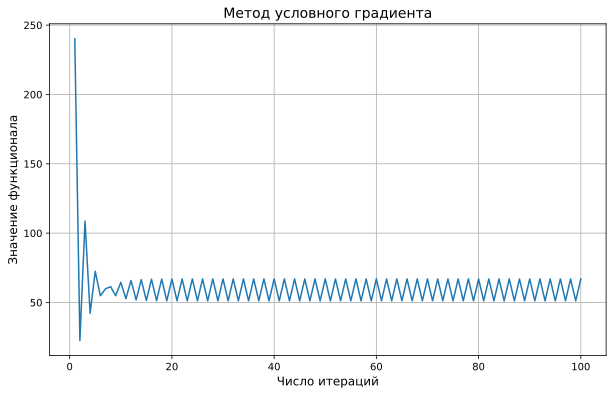

In [50]:
print(f'Минимизирующее u_*: {result[0]}')
print(f'||u_*||: {np.linalg.norm(result[0])}')
print(f'Значение функционала J(u_*): {J4(result[0])}')
print_result('Метод условного градиента', result[1])


## Проверка

Аналитически полученное решение: $u_* = a + b$.

In [51]:
print(np.linalg.norm(result[0] - (a + b)))
print((J4(result[0]) - J4(a + b)) ** 2)

3.735099432539994
4287.035570494219


Пример 2:

$$ J(u) = \frac{1}{2}\left<Au, u \right>+\left< b, u \right> \to \inf $$

$$ U = \{u \in H \ | \ ||u|| \geq 1 \} $$

$$ A = \begin{bmatrix} 4 & 1 & 0 & 0 \\ 1 & 3 & 1 & 0 \\ 0 & 1 & 2 & 1 \\ 0 & 0 & 1 & 1 \end{bmatrix}, b = \begin{bmatrix} 7 \\ 0 \\ -7 \\ 0 \end{bmatrix} $$

In [52]:
A = np.array([[4, 1, 0, 0],
              [1, 3, 1, 0],
              [0, 1, 2, 1],
              [0, 0, 1, 1]])
b = np.array([7, 0, -7, 0])
J5 = lambda u: 0.5 * (A @ u) @ u + (b @ u)

In [53]:
u0 = np.zeros(4)
constraints = [{"type": "ineq", "fun": lambda u: np.linalg.norm(u) - 1}]
result = ConditionalGradientMethod(J5, u0, constraints)

Достигнуто максимальное количество итераций
Сходится на 100 итерациях
Значение функционала: -37.54796804301547


Минимизирующее u_*: [-0.46134507 -2.74897644 10.2184618  -9.86265983]
||u_*||: 14.47268915071579
Значение функционала J(u_*): -37.54796804301547


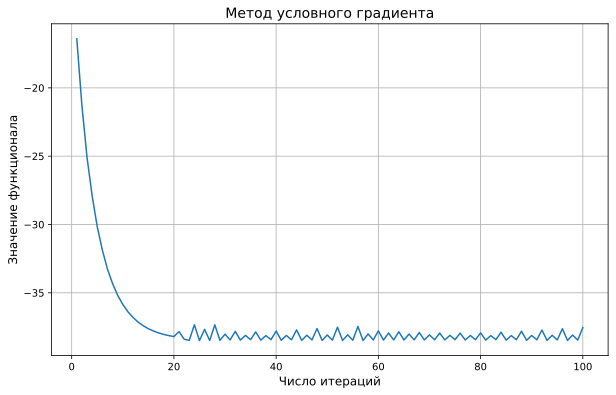

In [54]:
print(f'Минимизирующее u_*: {result[0]}')
print(f'||u_*||: {np.linalg.norm(result[0])}')
print(f'Значение функционала J(u_*): {J5(result[0])}')
print_result('Метод условного градиента', result[1])

## Проверка

Аналитически полученное решение: $ u_* = -A^{-1}b $

In [55]:
print(np.linalg.norm(result[0] + np.linalg.inv(A) @ b))
print((J5(result[0]) - J5(-np.linalg.inv(A) @ b)) ** 2)

0.6478810434934122
0.9063648471197884


Пример 3:

$$ J(u) = || Au - b||^2 \to \inf $$

$$ J'(u) = 2 A^*(Au - b), \ J''(u) = 2 A^*A $$

$$ U = \{u \in H \ | \ \|u\| \leq c \}$$

In [56]:
m, n = 10, 50
A = np.random.randn(m, n)
b = np.random.randn(m)
c = 1

In [57]:
J6 = lambda u: np.linalg.norm(A @ u - b) ** 2

In [58]:
u0 = np.random.randn(n)
constraints = [{'type': 'ineq', 'fun': lambda u: -np.linalg.norm(u) + c}]
result = ConditionalGradientMethod(J6, u0, constraints)

Достигнуто максимальное количество итераций
Сходится на 100 итерациях
Значение функционала: 0.17624202218615725


Минимизирующее u_*: [-0.22474332 -0.09420945  0.63848386 -0.66081832 -0.22094787 -0.14932638
 -0.37428502 -0.29792977  0.00293746  0.04735205  0.72470735  0.17823851
 -0.55007728 -0.46682138  0.46039058  0.5082833   0.01793994  0.39684339
  0.04020202 -0.06752693  0.47031724 -0.1834132   0.07152577 -0.06789107
  0.19630199 -0.9870173   0.40191254 -0.31386056  0.44470132  0.22636527
  0.5996253   0.58934261  0.58050891 -1.03489171  0.50977811 -0.41563962
  0.10840762  0.57037914 -0.02398499  0.10063603  0.57665798 -0.34919847
  0.31586913  0.22169216 -1.36125421 -0.47403392  0.12236591 -0.46665541
  0.05392101 -0.04779843]
||u_*||: 3.2432073623248163
Значение функционала J(u_*): 0.17624202218615725


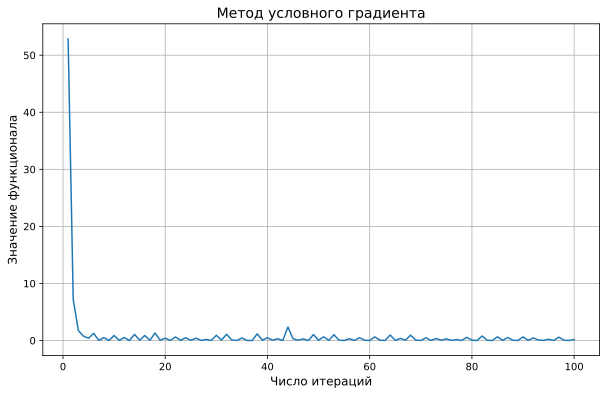

In [59]:
print(f'Минимизирующее u_*: {result[0]}')
print(f'||u_*||: {np.linalg.norm(result[0])}')
print(f'Значение функционала J(u_*): {J6(result[0])}')
print_result('Метод условного градиента', result[1])